In [1]:
import pdb
import copy
import pickle
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import seaborn as sns

#### Setting up the directories:

In [2]:
data_dir = 'omniglot-master/python'
background_folder = '/images_background'
evaluation_folder = '/images_evaluation'

#### Building up the alphabet dictionaries: training, validation and evaluation dicts.

In [3]:
background_alphabets_dictionary = {}
for alphabet in os.listdir(data_dir+background_folder):
    background_alphabets_dictionary[alphabet] = {char : os.listdir(data_dir+background_folder+'/'+alphabet+'/'+char) for char in os.listdir(data_dir+background_folder+'/'+alphabet)}
    
evaluation_alphabets_dictionary = {}
for alphabet in os.listdir(data_dir+evaluation_folder):
    evaluation_alphabets_dictionary[alphabet] = {char : os.listdir(data_dir+evaluation_folder+'/'+alphabet+'/'+char) for char in os.listdir(data_dir+evaluation_folder+'/'+alphabet)}
    
background_alphabets = list(background_alphabets_dictionary.keys())
evaluation_alphabets = list(evaluation_alphabets_dictionary.keys())

# Splitting up the background data to training and validation sets
validation_split = 0.3

valid_indexes = random.sample(range(0 , len(background_alphabets)), int(validation_split * len(background_alphabets)))

train_alphabets_dictionary = background_alphabets_dictionary.copy()
valid_alphabets_dictionary = {}

for i in valid_indexes:
    valid_alphabets_dictionary[background_alphabets[i]] = train_alphabets_dictionary.pop(background_alphabets[i])

#### Transforming an image into a tensor and optionally applying affline transforms:
Parameters:
- image_path : The path to the image file in the parent folder.
- training : Whether this image is for training or not. This is used to decied whether to apply affline transforms or not.
- evaluating : Whether it is for evaluation or not. This is used to choose the path to the image (background or evaluation).


In [4]:
def image_transforms(image_path , training = False , evaluating = False , data_dir = data_dir ,
                     background_folder = background_folder,evaluation_folder=evaluation_folder):
    ''' 
    Reading and transforming an image.
    
    Transformations are: Random rotation +-10 degrees.
                         Random shear +-30 degrees.
                         Random rescale in range [0.8 , 1.2].
                         Random translation (0.1 ,0.1).                
    '''
    
    if evaluating :
        img = Image.open(data_dir+evaluation_folder+image_path) # reading the image
        
        # Converting the validation PIL-image into 28x28x1 tensor
        transform = transforms.Compose([transforms.Resize(28),
                                        transforms.ToTensor()
                                       ])
    else :
        img = Image.open(data_dir+background_folder+image_path)
        
        if training:
            # Converting the training PIL-image into a 28x28x1 tensor and applying random rotation , shear , zoom and shift
            transform = transforms.Compose([transforms.RandomAffine(degrees=10, translate=(0.1,0.1),
                                                                    scale=(0.8,1.2), shear=30 , fillcolor=255),
                                            transforms.Resize(28),
                                            transforms.ToTensor()
                                           ])
        else:
            # Converting the validation PIL-image into 28x28x1 tensor
            transform = transforms.Compose([transforms.Resize(28),
                                        transforms.ToTensor()
                                       ])
            
    img = transform(img)
    return img

#### Visualizing The 28x28x1 image pixels.

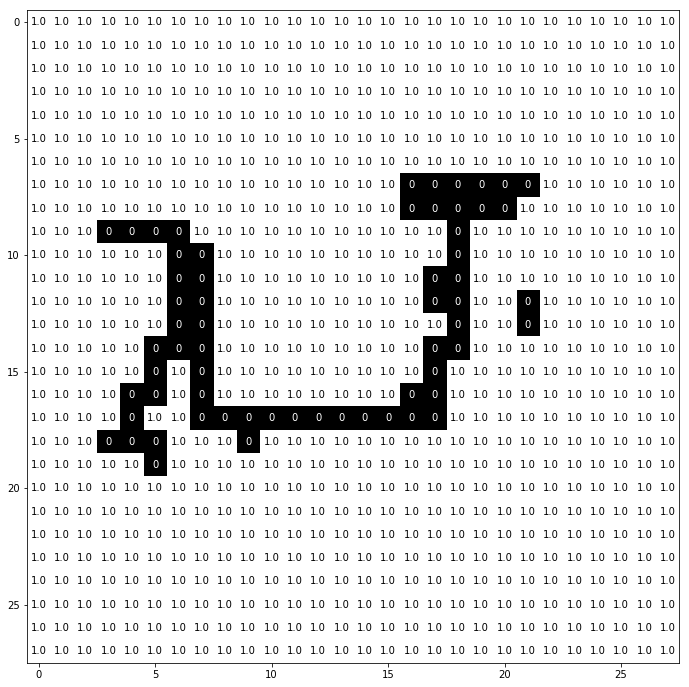

In [5]:
image = image_transforms('/Alphabet_of_the_Magi/character01/0709_01.png' ,training = True )
image = image.numpy()
img = np.squeeze(image[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

#### Getting a support set of K images, a test image and a label vector corresponding to each support set indicating whether a support set image is from the same character class of the test image or not. 
- repetitions : The number of K-way batches to be extraced.
- batch_size : How many k-way one-shot and test instances per batch.
- K : The number of the different character images in the support set.
- evaluating and training : Whether they are for evaluation, valdidation or training, it is passed on to the image_transforms function, in addition to choosing the corresponding dictionary.

All images at each instance are from the same chosen alphabet.

In [6]:
def get_K_way_batches(repetitions , batch_size = 1 ,K=20 ,training = False, evaluating = False,
                        evaluation_alphabets_dictionary=evaluation_alphabets_dictionary,
                        valid_alphabets_dictionary=valid_alphabets_dictionary,
                        train_alphabets_dictionary=train_alphabets_dictionary):
    
    if evaluating:
        alphabets_dictionary = copy.deepcopy(evaluation_alphabets_dictionary)
    elif training:
        alphabets_dictionary = copy.deepcopy(train_alphabets_dictionary)
    else:
        alphabets_dictionary = copy.deepcopy(valid_alphabets_dictionary)
    
    for r in range(repetitions):
        test_images = torch.tensor([])    # tensor of test images
        support_images = torch.tensor([]) # tensor of tensors of support images [[img1 ,..., imgK], [img1 ,..., imgK] ... so on].
        labels = torch.tensor([])         # tensor of labels               [[1 , 0 , ... , 0]], [[ 0, 1 , ... , 0]]... so on].
                                          # (1 for same, 0 for different).
        for i in range(batch_size):
            images_list = []
            labels_list = []
            alphabets = list(alphabets_dictionary.keys())

            # choosing an alphabet
            alph_index = random.randint(0 , len(alphabets)-1)
            alphabet = alphabets[alph_index]
#             print(alphabet)
            chars = list(alphabets_dictionary[alphabet].keys())

            # Choosing a character for the test image
            char_name_1 = chars[random.randint(0 , len(chars)-1)]
            char_imgs = alphabets_dictionary[alphabet][char_name_1]

            # Choosing the test image
            img_index_1 = random.randint(0 , len(char_imgs)-1)
            img_name_1 = char_imgs[img_index_1]

            test_image = image_transforms('/'+alphabet+'/'+char_name_1+'/'+img_name_1, training=training , evaluating=evaluating)

            used_chars = []
            target_there = False
            repeat = False
            # Choosing characters for the support set
            for j in range(K):
                char_name = chars[random.randint(0 , len(chars)-1)]
                while True:
                    # Making sure that each character is unique as long as there are enough characters.
                    if (char_name not in used_chars and len(used_chars) < len(chars)) or repeat:
                        # Adding the used char into the list
                        used_chars.append(char_name)

                        # Choosing a character drawing (image)
                        char_imgs = alphabets_dictionary[alphabet][char_name]
                        img_index = random.randint(0 , len(char_imgs)-1)
                        img_name = char_imgs[img_index]

                        image = image_transforms('/'+alphabet+'/'+char_name+'/'+img_name, training = training , evaluating=evaluating)
                        if char_name_1 == char_name :
                            label = 1
                            target_there = True
                        else:
                            label = 0

                        images_list.append(image)
                        labels_list.append(label)

                        repeat = False
                        # making sure that there is a true labeled character
                        if len(used_chars) == K and not target_there:
                            char_name = char_name_1
                            # replacing the last one with the true instance
                            del images_list[-1]
                            del labels_list[-1]
                            repeat = True
                            continue
                        break
                    # Choosing again while there is room for more
                    elif char_name in used_chars and len(used_chars) < len(chars) :
                        char_name = chars[random.randint(0 , len(chars)-1)]
                        continue

                    elif len(used_chars) >= len(chars):
                        # Checking if the alphabet has characters less than K
                        missing = K - len(used_chars)
                        if missing > 0 :
                            repeat = True
                            while True:
                                char_name = chars[random.randint(0 , len(chars)-1)]
                                if char_name != char_name_1:
                                    break
                            continue

            # Concatenating the new images and their associated label
            test_images = torch.cat((test_images, test_image), dim = 0)
            support_images = torch.cat((support_images , torch.stack(images_list , dim =1)) , dim = 0)
            labels = torch.cat((labels , torch.FloatTensor([labels_list])) , dim =0)
        
        yield  test_images, support_images, labels


### Training function
- prototypical_network : The model instance.
- optimizer : An optimizer instance.
- scheduler :  The learning rate decay step scheduler.
- n_epochs : The number of epochs.
- one_shot_repetitions : The number of K-way batches to be extraced for one shot testing.
- max_accuracy : Maximum one-shot accuracy scored during validation.
- MODEL : The name of the model to be saved with.

Returns the maximum  validation accuracy scored, in addition to 4 lists corresponding to the progress of losses and accuracies accross the training epochs.

#### Cosine Annealing Scheduler for the SGDR:
Refering to the [article](https://medium.com/38th-street-studios/exploring-stochastic-gradient-descent-with-restarts-sgdr-fa206c38a74e) and the [paper](https://arxiv.org/pdf/1608.03983.pdf), this method has shown effectiveness in finding a stable "hopefully global" minima after a substantial amount of epochs.
I have chosen to use a variable cycle-length throughout the training process via increasing the cycle-length by 25% after each cycle.

In [7]:
def Train_One_Shot_Model(prototypical_network, optimizer , n_epochs, batch_size, one_shot_repetitions,
                         max_accuracy, MODEL='Model_State'):
    
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []
#     # for the SGDR's restarts
#     cycle_restart = True
#     cycle_begun = 0
  
    for epoch in range(1, n_epochs+1):
        
#         if (epoch-1) == (cycle_begun+scheduler_cycle):
#             cycle_restart = True
            
#         if cycle_restart :
#             scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, scheduler_cycle) # restarting
#             print('Cycle Started..')
#             scheduler_cycle = int(1.25 * scheduler_cycle)  # increasing the next cycle by 25%
#             cycle_restart = False
#             cycle_begun = epoch-1

#         scheduler.step()

        epoch_train_loss = []
        epoch_valid_loss = []
        epoch_train_acc = []
        epoch_valid_acc = []
        
        ######################
        # Training the model #
        ######################
        prototypical_network.train()
#         pdb.set_trace() # Debugging
        for image , support_set , labels in get_K_way_batches(one_shot_repetitions, batch_size, K=20 , training = True):
            image, support_set = image.cuda(), support_set.cuda()

            optimizer.zero_grad() # Clearing the gradients of all optimized variables

            # Passing in the images with an addtional dimention for the network to work -> images.shape = (batch_size,1,105,105)
            output = prototypical_network.K_Way_Dists(image, support_set, K=20)

            loss , acc = Prototypical_Loss_and_Acc(output.cpu() , labels, batch_size) # Calculating the mean batch loss and accuracy
            loss.backward() # Computing the loss gradients with respect to model parameters
            optimizer.step() # Updating parameters
            
            epoch_train_loss.append(loss.item()) # Adding the mean batch training loss
            epoch_train_acc.append(acc.item()) # Adding the mean batch training accuracy
            # Cleaning gpu by moving variables back to cpu to be overridden
            image, support_set, output = image.cpu(), support_set.cpu(), output.cpu()


        ########################  
        # Validating the model #
        ########################
        prototypical_network.eval()
        with torch.no_grad():
            for image , support_set , labels in get_K_way_batches(one_shot_repetitions , batch_size , K=20):
                image, support_set = image.cuda(), support_set.cuda()
                
                output = prototypical_network.K_Way_Dists(image, support_set, K=20)
                loss , acc = Prototypical_Loss_and_Acc(output.cpu() , labels, batch_size) # Calculating the mean batch loss and accuracy
                epoch_valid_loss.append(loss.item()) # Adding the mean batch training loss
                epoch_valid_acc.append(acc.item()) # Adding the mean batch training accuracy
                # Cleaning gpu by moving variables back to cpu to be overridden
                image, support_set, output = image.cpu(), support_set.cpu(), output.cpu()


        # calculate average losses and accuracies accross the epoch
        train_loss.append(np.mean(epoch_train_loss))
        valid_loss.append(np.mean(epoch_valid_loss))
        train_acc.append(np.mean(epoch_train_acc))
        valid_acc.append(np.mean(epoch_valid_acc))     


        # Monitoring training and validation progress 
        print('Epoch{:3d}: Training Loss:{:.3f}\tValidation Loss:{:.3f}\tTraining Accuracy:{:.3f}  \tValidation Accuracy:{:.3f}'.format(
            epoch, train_loss[-1], valid_loss[-1] ,train_acc[-1], valid_acc[-1]))

        # saving the model if one-shot validation accuracy has increased
        if valid_acc[-1] >= max_accuracy:
            print('\t\tValidation accuracy increased ({:.6f} --> {:.6f}).  Model Saved !'.format(max_accuracy,valid_acc[-1]))
            torch.save(prototypical_network.state_dict(), MODEL+'.pt')
            max_accuracy = valid_acc[-1]
        
    return max_accuracy, train_loss, valid_loss , train_acc, valid_acc

### Defining the Prototypical Network Model : 

The network architecture is taken from this [paper](https://arxiv.org/pdf/1703.05175.pdf).
It consists of 4 convolutional blocks, each block is made of :
    - 64-filter 3 × 3 convolution.
    - Batch normalization.
    - ReLU nonlinearity.
    - and 2 × 2 max-pooling.

Given a 28x28x1 input, the output of each block will be :
    * The output of the first convolution block is : (28 - 3 + (2*1) + 1)/2 = 14x14x64
    * The output of the second convolution block is :(14 - 3 + 1)/2 = 6x6x64
    * The output of the third convolution block is : (6 - 3 + 1)/2 = 2x2x64
    * The output of the fourth convolution block is : (2 - 3 + (2*1) +1)/2 = 1x1x64


In [8]:
class Prototypical_Network(nn.Module):

    def __init__(self):
        super(Prototypical_Network, self).__init__()
        
        self.conv1 =  nn.Sequential(nn.Conv2d(1, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2)
                                    )
        self.conv2_3= nn.Sequential(nn.Conv2d(64, 64, 3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2)
                                    )
        self.conv4 =  nn.Sequential(nn.Conv2d(64, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2)
                                    )
    def forward(self, x):
        # embedding an image
        x = self.conv1(x)
        x = self.conv2_3(x)
        x = self.conv2_3(x)
        x = self.conv4(x)

        x = x.view(x.shape[0], -1)
        return x

    def calculate_dist(self, x1, x2):
        # computing the squared euclidean distance
        dist = torch.pow(x1 - x2, 2).sum(1)
        return dist
    
    def K_Way_Dists(self, images, support_images, K=20):
        # embedding the test images
        x1 = self.forward(images.unsqueeze(1))
        
        dists = []
        # computing the distance for the kth images and the test images in the entire batch
        for k in range(K):
            # embedding the kth support images
            x2 = self.forward(support_images[:,k,:,:].unsqueeze(1))
            # calculating the distances
            dist = self.calculate_dist(x1,x2)
            dists.append(dist)      # the dists here are constructed such that the shape is Kxbatch_size

        # fixing the shape of the dists to be batch_sizexK
        dists = torch.stack(dists).t()
        return dists

In [9]:
def Prototypical_Loss_and_Acc(dists , labels, batch_size):
    target_idx = list((labels==1).nonzero()[:,1].numpy())
    log_softmax =F.log_softmax(-dists, dim=1)
    pred_score = torch.tensor([])
    for i in range(batch_size):
        pred_score = torch.cat((pred_score , log_softmax[i,target_idx[i]].unsqueeze(0)),dim=0)
    loss = (-pred_score).mean()
    _, pred = torch.max(-dists, 1)
    acc = (pred.eq((labels==1).nonzero()[:,1]).float()).mean()
    return loss , acc

In [10]:
# initializing the network, optimizer and scheduler

prototypical_network = Prototypical_Network()
prototypical_network.cuda()

# specifying the optimizer to be stochastic gradient descent with Adam, and a learning rate scheduler.
optimizer = optim.Adadelta(prototypical_network.parameters(), lr=1e-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 20 , gamma= 0.5)

##### Starting the training process
I have chosen the starting cycle-length to be 10, and the number of epochs to be 1810.

Therefore, the cosine scheduler restarts at epochs :
0, 12, 27, 45, 67, 94, 127, 168, 219, 282, 360, 457, 578, 729, 917, 1152 and 1445.

In [ ]:
max_accuracy, train_loss, valid_loss, train_acc, valid_acc = Train_One_Shot_Model(prototypical_network, optimizer,
#                                                                                   scheduler_cycle = 10,
                                                                                  n_epochs = 300 , batch_size = 32,
                                                                                  one_shot_repetitions= 100, max_accuracy= 0.1,
                                                                                  MODEL = 'Prototypical_Network_adadelta')

Epoch  1: Training Loss:2.970	Validation Loss:2.367	Training Accuracy:0.170  	Validation Accuracy:0.327
		Validation accuracy increased (0.100000 --> 0.327188).  Model Saved !
Epoch  2: Training Loss:2.347	Validation Loss:2.150	Training Accuracy:0.270  	Validation Accuracy:0.380
		Validation accuracy increased (0.327188 --> 0.380000).  Model Saved !
Epoch  3: Training Loss:2.140	Validation Loss:1.932	Training Accuracy:0.343  	Validation Accuracy:0.463
		Validation accuracy increased (0.380000 --> 0.463438).  Model Saved !
Epoch  4: Training Loss:1.955	Validation Loss:1.935	Training Accuracy:0.392  	Validation Accuracy:0.452
Epoch  5: Training Loss:1.858	Validation Loss:1.790	Training Accuracy:0.416  	Validation Accuracy:0.497
		Validation accuracy increased (0.463438 --> 0.497500).  Model Saved !
Epoch  6: Training Loss:1.756	Validation Loss:1.655	Training Accuracy:0.447  	Validation Accuracy:0.530
		Validation accuracy increased (0.497500 --> 0.530312).  Model Saved !
Epoch  7: Traini

#### Visualizing the training progress
The vertical lines indicate when the cycles were restarted.

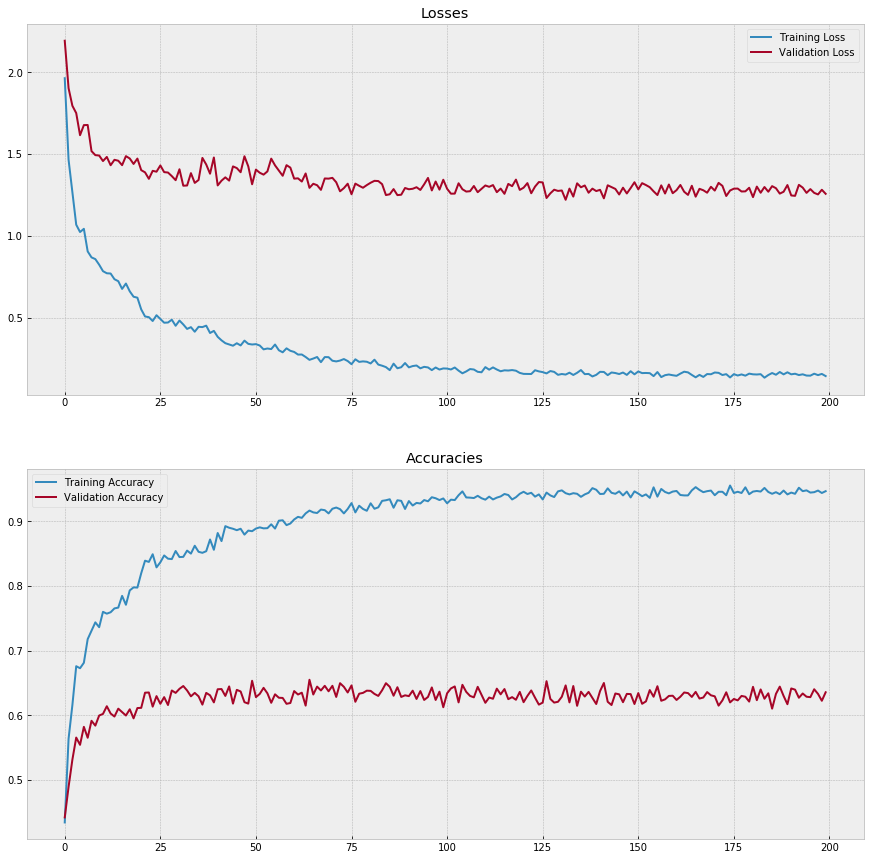

In [12]:
restarts = []#0, 12, 27, 45, 67, 94, 127, 168, 219, 282, 360, 457, 578, 729, 917, 1152, 1445]
plt.style.use('bmh')
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title('Losses')
plt.plot(train_loss , label = 'Training Loss',)
plt.plot(valid_loss , label = 'Validation Loss')
for xc in restarts:
    plt.axvline(x=xc, color='k',alpha = 0.2, linestyle='--')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.title('Accuracies')
plt.plot(train_acc , label = 'Training Accuracy')
plt.plot(valid_acc , label = 'Validation Accuracy')
for xc in restarts:
    plt.axvline(x=xc, color='k',alpha = 0.2, linestyle='--')
plt.legend(loc='best')
plt.show()

In [20]:
# Reloading the best model found.
prototypical_network.load_state_dict(torch.load('Prototypical_Network.pt'))

After : Epoch 858: Training Loss:0.608	Validation Loss:2.304	Training Accuracy:0.797  	Validation Accuracy:0.603
Evaluation Loss = 2.454			 Evaluation Accuracy = 0.481 +-0.040

## Evaluation :

Using my own "greedy" one-shot trials:

In [16]:
eval_one_shot_loss = []
eval_one_shot_accuracy = []

prototypical_network.eval()
with torch.no_grad():
    # 20-way One_Shot evaluation
    for image , support_set , labels in get_K_way_batches(repetitions = 200, batch_size=128 ,K=20 , evaluating = True):
        image, support_set = image.cuda(), support_set.cuda()
        output = prototypical_network.K_Way_Dists(image, support_set, K=20)
        loss , acc = Prototypical_Loss_and_Acc(output.cpu() , labels, 128)
        eval_one_shot_loss.append(loss.item()) # Adding the mean training loss
        eval_one_shot_accuracy.append(acc.item())
        # Cleaning
        image, support_set, output = image.cpu(), support_set.cpu(), output.cpu()
    
print("Evaluation Loss = {:.3f}\t\t\t Evaluation Accuracy = {:.3f} +-{:.3f}".format(np.mean(eval_one_shot_loss),np.mean(eval_one_shot_accuracy),np.std(eval_one_shot_accuracy)))

Evaluation Loss = 2.454			 Evaluation Accuracy = 0.481 +-0.040


#### Prediction insight :

Index of the chosen image :  17


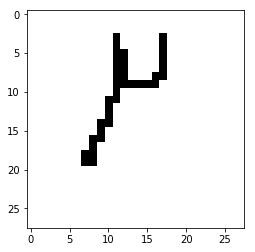

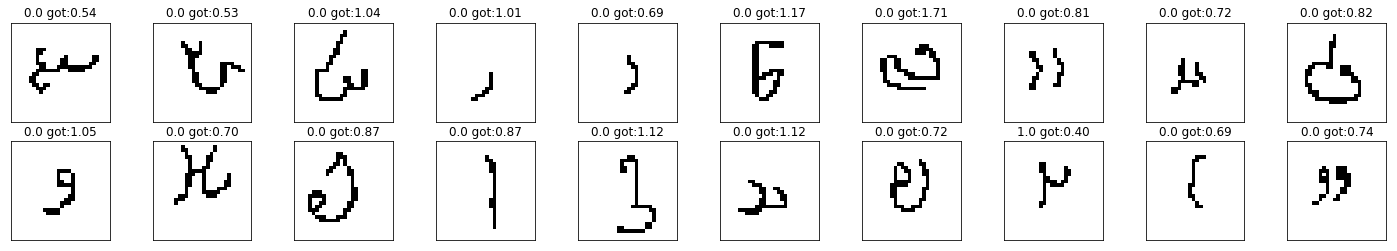

In [17]:
test_images, support_images, labels = next(iter(get_K_way_batches(1,K=20 ,evaluating = True )))

output = prototypical_network.K_Way_Dists(test_images.cuda(), support_images.cuda(), K=20)
_, pred = torch.max(-output, 1)
print('Index of the chosen image : ' , pred.item())

i = 0
im = test_images[i]
im = np.array(im)
plt.imshow(np.squeeze(im), cmap='gray')

fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.array(support_images[i,idx]), cmap='gray')
    ax.set_title(str((labels[i][idx]).item())+' got:{:.2f}'.format((output[i][idx]).item()))

##### Using the setup runs available with the dataset :

In [18]:
prototypical_network.cpu()
prototypical_network.eval()

folder = 'omniglot-master/python/one-shot-classification'
transform = transforms.Compose([transforms.Resize(28),transforms.ToTensor()])
total_accuracy = []

for i in range(1 , 21):
    run_accuracy = 0.0
    
    rs = str(i)
    if len(rs)==1:
        rs = '0' + rs
    with open(folder+'/run'+rs+'/class_labels.txt') as f:
        content = f.read().splitlines()   
    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    ntrain = len(train_files)
    ntest = len(test_files)
    
    # Setting up the support set in a [1 , 20 , 105 , 105]-shaped tensor.
    support_images = torch.tensor([])
    for train_file in train_files:
        img = Image.open(folder+'/'+train_file)
        img = transform(img)
        support_images = torch.cat((support_images , img) , dim=0)
    support_images=support_images.unsqueeze(0)
    # Getting a test image and turning it into a [1 , 105 , 105]-shaped tensor
    for (j , test_file) in enumerate(test_files):
        test_image = Image.open(folder+'/'+test_file)
        test_image = transform(test_image)
        
        # Predict the class of the test image from the support images
        output = prototypical_network.K_Way_Dists(test_image, support_images, K=20)
        _, pred = torch.max(-output, 1)
        if train_files[pred.item()] == answers_files[j]:
            run_accuracy += 1.0
    run_accuracy = 100 * run_accuracy / ntest
    total_accuracy.append(run_accuracy)
    
    print (" run" + rs + "\t Error :" + str(100-run_accuracy) + "% \t Accuracy :" + str(run_accuracy) + '%')
print (" Average Error : " + str(100 - np.mean(total_accuracy)) + "%" + '\t Average Accuracy : '+ str(np.mean(total_accuracy)) + "%" )

 run01	 Error :35.0% 	 Accuracy :65.0%
 run02	 Error :55.0% 	 Accuracy :45.0%
 run03	 Error :40.0% 	 Accuracy :60.0%
 run04	 Error :50.0% 	 Accuracy :50.0%
 run05	 Error :30.0% 	 Accuracy :70.0%
 run06	 Error :30.0% 	 Accuracy :70.0%
 run07	 Error :40.0% 	 Accuracy :60.0%
 run08	 Error :55.0% 	 Accuracy :45.0%
 run09	 Error :65.0% 	 Accuracy :35.0%
 run10	 Error :55.0% 	 Accuracy :45.0%
 run11	 Error :40.0% 	 Accuracy :60.0%
 run12	 Error :55.0% 	 Accuracy :45.0%
 run13	 Error :45.0% 	 Accuracy :55.0%
 run14	 Error :35.0% 	 Accuracy :65.0%
 run15	 Error :30.0% 	 Accuracy :70.0%
 run16	 Error :30.0% 	 Accuracy :70.0%
 run17	 Error :50.0% 	 Accuracy :50.0%
 run18	 Error :55.0% 	 Accuracy :45.0%
 run19	 Error :60.0% 	 Accuracy :40.0%
 run20	 Error :40.0% 	 Accuracy :60.0%
 Average Error : 44.75%	 Average Accuracy : 55.25%
